In [1]:
import torch

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from warmup_scheduler import GradualWarmupScheduler
from models import PretrainModel
from dataset import ExternalDataset, chexpert_classes, chest14_classes
from utils import seed_everything


# Chexpert

In [3]:
train_df = pd.read_csv('../../dataset/external_dataset/ext_csv/chexpert_train.csv')
valid_df = pd.read_csv('../../dataset/external_dataset/ext_csv/chexpert_valid.csv')
images_dir='.'
batch_size = 4
image_size = 384


In [4]:
len(train_df)

94120

In [5]:
chexpert_classes

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [6]:
dst_classes=chexpert_classes

In [7]:
train_dataset = ExternalDataset(df=train_df,images_dir=images_dir,image_size=image_size, mode='train',classes=dst_classes)
valid_dataset = ExternalDataset(df=valid_df,images_dir=images_dir,image_size=image_size, mode='valid',classes=dst_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset), num_workers=15)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=SequentialSampler(valid_dataset), num_workers=15)


/home/sergey/anaconda3/envs/covid19/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/sergey/anaconda3/envs/covid19/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)
/home/sergey/anaconda3/envs/covid19/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [20]:
batch=next(iter(valid_loader))

In [21]:
images, labels = batch

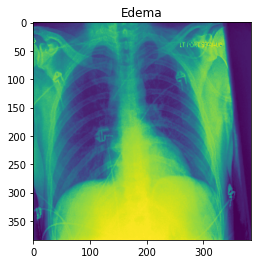

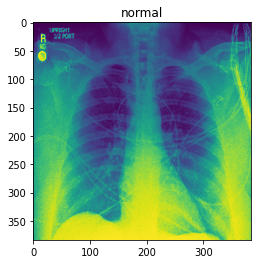

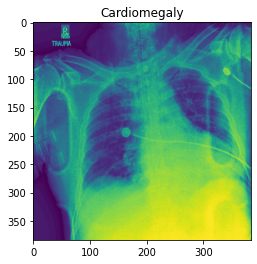

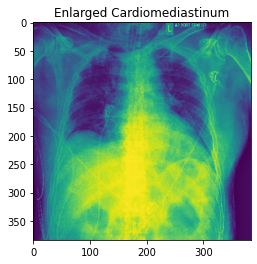

In [22]:
images=images.detach().cpu().numpy()
labels=labels.detach().cpu().numpy()

for img,label in zip(images, labels):
    plt.figure()
    plt.imshow(img[0])
    ones=np.where(label==1)[0]
    if len(ones)!=0:
        plt.title(dst_classes[ones[0]])
    else:
        plt.title('normal')

# Mutual info

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
from tqdm import tqdm
import numpy as np
import sklearn
import sklearn.feature_selection

In [9]:
from models import PretrainModel
import yaml

cfg='configs/eb3_384_deeplabv3plus.yaml'
with open(cfg,'rt') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)



In [10]:
encoder_weights = cfg['encoder_weights']
pretrained_path = 'chexpert_chest14_pretrain/timm-efficientnet-b3_384_pretrain_step0.pth'
pretrained_num_classes = None

In [11]:
model = PretrainModel(
            encoder_name=cfg['encoder_name'],
            encoder_weights=encoder_weights,
            classes=len(dst_classes),
            in_features=cfg['in_features'],
            pretrained_path=pretrained_path,
            pretrained_num_classes=len(dst_classes)
        )

Load pretrain: chexpert_chest14_pretrain/timm-efficientnet-b3_384_pretrain_step0.pth


In [12]:
model.cuda()
model.eval()

PretrainModel(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Swish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): Swish()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Iden

In [19]:
device='cuda:0'

def calc_XY(idx):
    
    max_len=3000
    X=[]
    Y=[]
    for images,labels in tqdm(valid_loader, desc='calc_features'):
        images=images.to(device)
        labels=labels.to(device)
        feats=model.encoder.forward(images)
        feats=feats[idx].detach().cpu().numpy()
        _,c,h,w=feats.shape
        stride=max(h//3,1)
        stride_c=max(c//3,1)
        feats=feats[:,::stride_c,::stride,::stride]
        feats=np.reshape(feats, (len(feats),-1))

        labels=labels.detach().cpu().numpy()
        
        X.append(feats)
        Y.append(labels)
        
        if len(X)>max_len:
            break

    X=np.concatenate(X,axis=0)
    Y=np.concatenate(Y,axis=0)
    return X,Y


In [15]:
X,Y = calc_XY(idx=0)

calc_features:   5%|▌         | 304/6042 [00:08<02:33, 37.39it/s]


KeyboardInterrupt: 

In [17]:
from multiprocessing import Pool

In [20]:
for idx in [0,1,2,3,4,5]:
    X,Y = calc_XY(idx=idx)
    
    def calc_mi(i): 
        return sklearn.feature_selection.mutual_info_classif(X, Y[:,i], discrete_features=False)
        
    with Pool(24) as pool:
        mis=pool.map(calc_mi, list(range(Y.shape[1])))
    mi=np.concatenate(mis,axis=0)            
    print(f'{idx} mi={np.mean(mi)} max={np.max(mi)} q95={np.quantile(mi,0.95)}')

calc_features:   0%|          | 0/6042 [00:00<?, ?it/s]

0 mi=0.004133205527435811 max=0.03281058400696257 q95=0.017262317577238506


calc_features:   0%|          | 0/6042 [00:00<?, ?it/s]

1 mi=0.0038458870917677476 max=0.04007991017397239 q95=0.015966888425150216


calc_features:   0%|          | 0/6042 [00:00<?, ?it/s]

2 mi=0.0018026182008436156 max=0.025452244232770926 q95=0.007814930631506734


calc_features:   0%|          | 0/6042 [00:00<?, ?it/s]

3 mi=0.0016388199307605343 max=0.02992335441122318 q95=0.007071994506539059


calc_features:   0%|          | 0/6042 [00:00<?, ?it/s]

4 mi=0.0022078512938990304 max=0.05894885216433732 q95=0.009115486162155696


calc_features:  50%|████▉     | 3000/6042 [01:12<01:13, 41.29it/s]


5 mi=0.004663985581347513 max=0.20398503791200828 q95=0.01913440061706118


In [27]:
np.quantile(mi,0.95)

0.005529472021328651